# HM4

# Problem 1 – Comparison study 20 pts (30 pts for undergraduate students)

Notebooks neaclassX perform transfer learning on resnet18 using NEUdata dataset.

What is transfer learning? Please answer using your words and illustrate it with the examples we showed in class.

``` I could't find the notebook neaclassX on Canvas but Transfer Learning is when you use the weight pretrain on a different dataset and maybe task (regression, self-supervised learning, etc) and use it as the starting point for training on your dataset. For example if we train a model on mini-imagenet dataset and then save the model then change the last layer (classifer) to the number of classes in MNIST dataset to start a training on that dataset. There are several different ways to do transfer learninig but freezing some of the first layers is a common approach in other to get better performance since usually the first layer learns basic features of the input and doesn't need to be change that much; this is specially important when the pretrained model was trained on a significantly larger dataset.```

You have 2 renditions of the same notebook to illustrate different factors that affect the learning (neaclassA.ipynb, neaclassB.ipynb, in Week 7 module).

Explain where the differences are that make the loss plot different between the two notebooks. If you are running from colab, use the colab access to the github repo to store data on your google drive, as explained in neaclass_ex.ipynb (Week 5 module).

``` The difference between the two notebooks is that A use randaom initialization for the resnet but B uses IMAGENET1K_V1 weights for training. The second training in B also freezes the weights form IMAGENET1K_V1 meaninig that through the training they are not changing and only the last linear layer at the end (fc) is learning its weights ```


Finally, replace resnet18 with alexnet and repeat the training (save and submit it as neaclassC.ipynb).

In [2]:
import torch
torch.__version__

'2.1.2'

In [2]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='../datasets/NEUdata', loader = load_image, extensions = ('.bmp',))


## We need to write a transform to make it compatible with resnet18 (size 224x224x3, and type tensor)

In [157]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='../datasets/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

### Note that load_image  needed to return a PIL.Image for the transforms to be correctly applied


In [158]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

75
38


 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [137]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary
import copy

# orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
orig_model = models.alexnet(weights = models.AlexNet_Weights.IMAGENET1K_V1)


alt_model = copy.deepcopy(orig_model)
alt_model.classifier[-1] = nn.Linear(4096, 6)

# summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))
summary(alt_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [16, 6]                   --
+ Sequential: 1-1                        [16, 256, 6, 6]           --
|    + Conv2d: 2-1                       [16, 64, 55, 55]          23,296
|    + ReLU: 2-2                         [16, 64, 55, 55]          --
|    + MaxPool2d: 2-3                    [16, 64, 27, 27]          --
|    + Conv2d: 2-4                       [16, 192, 27, 27]         307,392
|    + ReLU: 2-5                         [16, 192, 27, 27]         --
|    + MaxPool2d: 2-6                    [16, 192, 13, 13]         --
|    + Conv2d: 2-7                       [16, 384, 13, 13]         663,936
|    + ReLU: 2-8                         [16, 384, 13, 13]         --
|    + Conv2d: 2-9                       [16, 256, 13, 13]         884,992
|    + ReLU: 2-10                        [16, 256, 13, 13]         --
|    + Conv2d: 2-11                      [16, 256, 13, 13]        

In [36]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = alt_model.to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter



N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.29821035663286843 Val Loss: 0.03564325859770179
Epoch: 1 Train Loss: 0.04319896584376693 Val Loss: 0.01688247376985505
Epoch: 2 Train Loss: 0.020602902093281347 Val Loss: 0.015217128260318484
Epoch: 3 Train Loss: 0.020133758316126963 Val Loss: 0.059567548933524735
Epoch: 4 Train Loss: 0.023673581070421886 Val Loss: 0.012885906190556278
Epoch: 5 Train Loss: 0.012658608761848883 Val Loss: 0.012067258342300958
Epoch: 6 Train Loss: 0.012429288493779798 Val Loss: 0.010873419904352264
Epoch: 7 Train Loss: 0.007272697984008119 Val Loss: 0.01825156613707996
Epoch: 8 Train Loss: 0.009632168957032262 Val Loss: 0.010395837653815857
Epoch: 9 Train Loss: 0.003144712018353554 Val Loss: 0.009969610865338933
Epoch: 10 Train Loss: 0.0023759486924973317 Val Loss: 0.010723053201696817
Epoch: 11 Train Loss: 0.0015413552820003435 Val Loss: 0.009852442850675098
Epoch: 12 Train Loss: 0.0013571917126925352 Val Loss: 0.00934609099165659
Epoch: 13 Train Loss: 0.0011617940536234527 Val Los

Text(0.5, 1.0, 'Loss Curves')

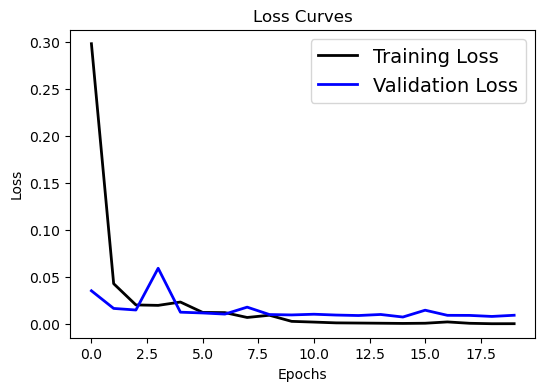

In [38]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

#### This is a different way of changing the resnet18

Let's get rid of the last layer of the resnet18 (output size 1000), because we have only 6 classes!

Plus, add the FlattenLayer to see what is the linearized size of the last AvgPool

We will use this shortened model (vec_model) to build upon it later, but first we will **freeze its parameters** (disable further training)


In [152]:
vec_model = copy.deepcopy(orig_model)
vec_model.classifier = nn.Sequential(*list(vec_model.classifier.children())[:-1])

for param in model.features.parameters():
    param.requires_grad = False

vec_model.classifier.append(nn.Linear(4096, 6))

# vec_model.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, 6),
#         )

# for param in vec_model.classifier.parameters():
#     param.requires_grad = True

summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [16, 6]                   --
+ Sequential: 1-1                        [16, 256, 6, 6]           --
|    + Conv2d: 2-1                       [16, 64, 55, 55]          23,296
|    + ReLU: 2-2                         [16, 64, 55, 55]          --
|    + MaxPool2d: 2-3                    [16, 64, 27, 27]          --
|    + Conv2d: 2-4                       [16, 192, 27, 27]         307,392
|    + ReLU: 2-5                         [16, 192, 27, 27]         --
|    + MaxPool2d: 2-6                    [16, 192, 13, 13]         --
|    + Conv2d: 2-7                       [16, 384, 13, 13]         663,936
|    + ReLU: 2-8                         [16, 384, 13, 13]         --
|    + Conv2d: 2-9                       [16, 256, 13, 13]         884,992
|    + ReLU: 2-10                        [16, 256, 13, 13]         --
|    + Conv2d: 2-11                      [16, 256, 13, 13]        

#### Train vec_model

In [153]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    #change the LR here (per epoch)
    scheduler.step()
    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.27404851488924276 Val Loss: 0.07923247570349638
Epoch: 1 Train Loss: 0.12045960473517577 Val Loss: 0.03243014238787031
Epoch: 2 Train Loss: 0.061891249044565486 Val Loss: 0.039275853402662174
Epoch: 3 Train Loss: 0.03344769967913938 Val Loss: 0.09827721033760003
Epoch: 4 Train Loss: 0.021397275858713934 Val Loss: 0.01823669135716811
Epoch: 5 Train Loss: 0.011717151542300902 Val Loss: 0.01766978327917681
Epoch: 6 Train Loss: 0.004714406067845024 Val Loss: 0.005253359111353156
Epoch: 7 Train Loss: 0.001030380008511808 Val Loss: 0.003612706436223035
Epoch: 8 Train Loss: 0.0009863208836880706 Val Loss: 0.002268115802172887
Epoch: 9 Train Loss: 0.0010047636325058798 Val Loss: 0.002142009961864077
Epoch: 10 Train Loss: 0.0007848463814904487 Val Loss: 0.002132287631962084
Epoch: 11 Train Loss: 0.0005336563077798928 Val Loss: 0.001965518124985752
Epoch: 12 Train Loss: 0.0004824463721706707 Val Loss: 0.0018739420595825084
Epoch: 13 Train Loss: 0.00046626328701677267 Val L

Text(0.5, 1.0, 'Loss Curves')

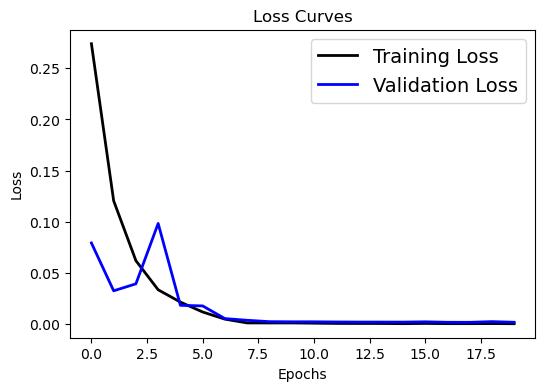

In [154]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Problem 2 – Autoencoder 30 pts

Design a convolutional autoencoder for a dataset of images 3 x 224 x224. The output of the encoder should have the total dimension (when flatened) equal to 512. Train it on NEU data for 50 epochs.

When you finish training, create 50 reconstructions (𝑥) of randomly selected test NEU images (from NEUdata_split/Test).

Test the modified pretrained classifier (e.g. resnet18 from neaclassB) on these 50 reconstructed images and compare the accuracy with the 50 original images.

Your results do not have to be good, i.e. the autoencoder does not have to perfectly reconstruct. We will use ImageNet1K in the future to repeat this exercise.

Remember that you can always practice how to design encoder-decoder convolutional stack in a step by step fashion by crea􀆟ng a random tensor x the size of the previous layer output, and experimenting until you get the dimension you desire (similar to our in-class exercise).

The mirrored parameters for the transposed convolutions (as explained in the slide named HW4) will always work but they may create artefacts (which is not important in this case). Consult the online code whose link I gave in the slides.

In [450]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 2, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten()
        )

summary(model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 512]                 --
+ Conv2d: 1-1                            [16, 16, 75, 75]          448
+ ReLU: 1-2                              [16, 16, 75, 75]          --
+ MaxPool2d: 1-3                         [16, 16, 37, 37]          --
+ Conv2d: 1-4                            [16, 8, 37, 37]           1,160
+ ReLU: 1-5                              [16, 8, 37, 37]           --
+ MaxPool2d: 1-6                         [16, 8, 18, 18]           --
+ Conv2d: 1-7                            [16, 2, 16, 16]           146
+ ReLU: 1-8                              [16, 2, 16, 16]           --
+ Flatten: 1-9                           [16, 512]                 --
Total params: 1,754
Trainable params: 1,754
Non-trainable params: 0
Total mult-adds (M): 66.33
Input size (MB): 9.63
Forward/backward pass size (MB): 12.99
Params size (MB): 0.01
Estimated Total Size (MB): 22.63

In [451]:
model = nn.Sequential(
            nn.ConvTranspose2d(2, 8, 
                               kernel_size=3, 
                               stride=4, 
                               padding=4, 
                               output_padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=2, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
summary(model, input_size=(16, 2, 16, 16), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 3, 224, 224]         --
+ ConvTranspose2d: 1-1                   [16, 8, 57, 57]           152
+ ReLU: 1-2                              [16, 8, 57, 57]           --
+ ConvTranspose2d: 1-3                   [16, 16, 112, 112]        1,168
+ ReLU: 1-4                              [16, 16, 112, 112]        --
+ ConvTranspose2d: 1-5                   [16, 3, 224, 224]         435
+ Sigmoid: 1-6                           [16, 3, 224, 224]         --
Total params: 1,755
Trainable params: 1,755
Non-trainable params: 0
Total mult-adds (M): 591.55
Input size (MB): 0.03
Forward/backward pass size (MB): 48.28
Params size (MB): 0.01
Estimated Total Size (MB): 48.32

In [454]:
#for typing
from typing import List, Callable

# training visualization
from tqdm import tqdm
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 2, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 8, 
                               kernel_size=3, 
                               stride=4, 
                               padding=4, 
                               output_padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=2, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    def eval_model(self, epoch: int, data_loader: torch.utils.data.DataLoader, optimizer: torch.optim,
                   criterion: nn.modules.loss, device: torch.device, mode: str):
        
        with tqdm(data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            n_loss = 0
            loss_ctr = 0
            for img, _ in tepoch:
                img = img.to(device)

                recon = self.forward(img)
                loss = criterion(recon, img)
                
                if mode == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                n_loss += loss.item()
                loss_ctr += 1

                tepoch.set_postfix(mode=mode, loss=n_loss/loss_ctr)

        if epoch % self.eval_step == 0 or mode == "test":
            self.hist[mode].append((n_loss/loss_ctr, img[:9], recon[:9]))
    
    @staticmethod
    def plot_encoder_decoder(outputs: List, title: str):
        fig= plt.figure(figsize=(9, 2))
        fig.suptitle(title)
        imgs = outputs[1].detach().cpu().numpy()
        recon = outputs[2].detach().cpu().numpy()
        for i, item in enumerate(imgs):
                plt.subplot(2, 9, i+1)
                plt.axis("off")
                plt.imshow(item[0], cmap="gray")

        for i, item in enumerate(recon):
            plt.subplot(2, 9, 9+i+1)
            plt.axis("off")
            plt.imshow(item[0], cmap="gray")
            
    def plot_autoencoder_results(self, num_epochs):
        
        for k in range(0, num_epochs//self.eval_step):
            Autoencoder.plot_encoder_decoder(self.hist["train"][k], title=f"train_{k}")
            Autoencoder.plot_encoder_decoder(self.hist["val"][k], title=f"val_{k}")
    
    def fit(self, train_loader, val_loader, optimizer: torch.optim, loss: nn.modules.loss, num_epochs: int, eval_step: int):
        self.eval_step = eval_step
        # check to run training on cpu or gpu
        device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        self.to(device)
        # Point to training loop video
        self.hist = {"train":[], "test":[], "val":[]}
        
        for epoch in range(1, num_epochs+1):
            self.train()
            self.eval_model(epoch = epoch, data_loader = train_loader, optimizer = optimizer,
                            criterion = loss, device = device, mode = "train")
            
            if epoch % self.eval_step == 0:
                self.eval()
                self.eval_model(epoch = epoch, data_loader = val_loader, optimizer = optimizer,
                                criterion = loss, device = device, mode = "val")
        
        
        self.plot_autoencoder_results(num_epochs)

Epoch 50: 100%|██████████| 38/38 [00:04<00:00,  8.65batch/s, loss=0.455, mode=val]


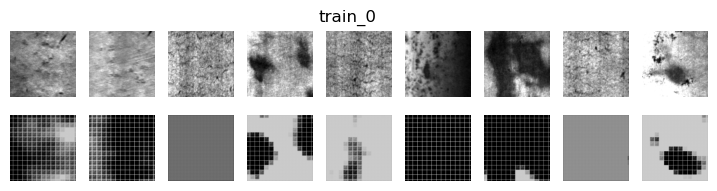

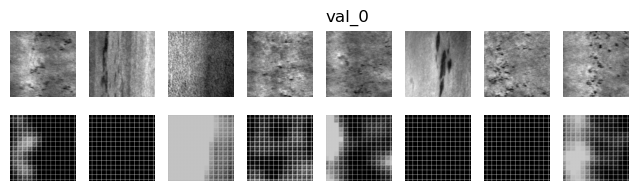

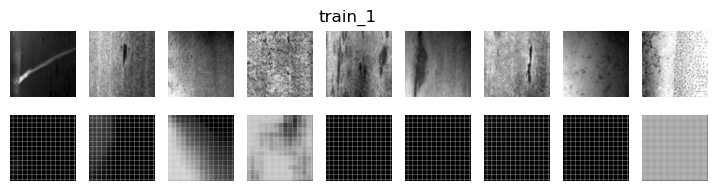

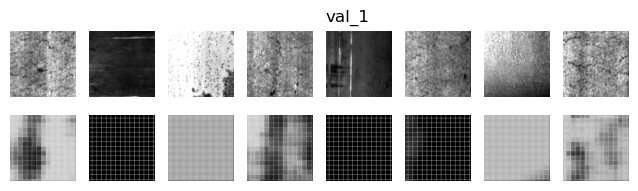

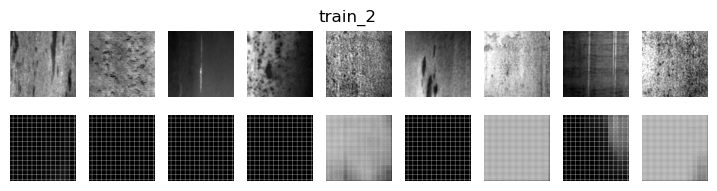

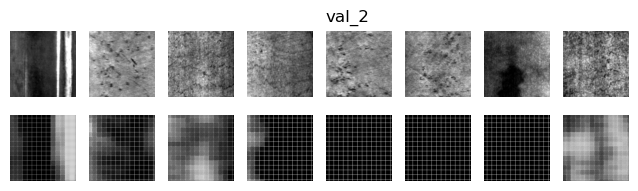

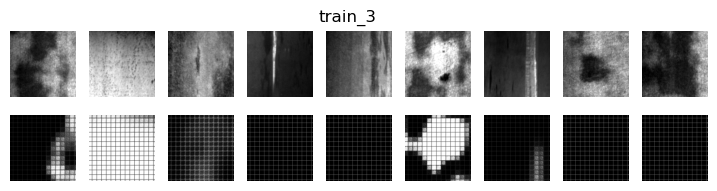

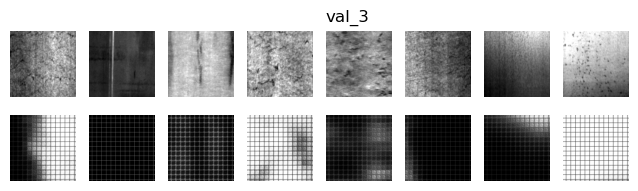

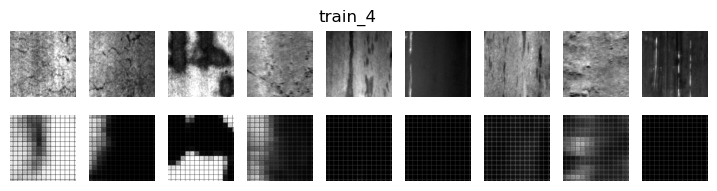

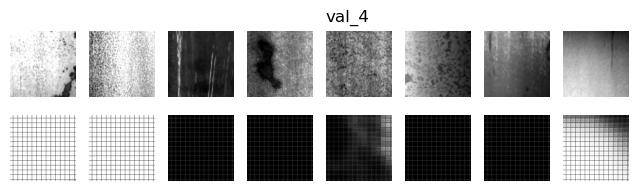

In [460]:
autoencoder = Autoencoder()

loss = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

autoencoder.fit(train_loader=trainloader, val_loader=valloader, optimizer=optimizer, loss=loss, num_epochs=50, eval_step=10)

In [470]:
orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)
criterion = nn.CrossEntropyLoss()
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = alt_model.to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter



N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    val_acc = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions = outputs.argmax(dim=1)
        # print(predictions.shape, labels.shape)

        val_acc += torch.sum(predictions == labels)/labels.shape[0]


        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {} acc: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader),
                  val_acc/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.8912903598944346 Val Loss: 0.306112429421199 acc: 0.9621710777282715
Epoch: 1 Train Loss: 0.2786366221308708 Val Loss: 0.13150256323186973 acc: 0.9835526347160339
Epoch: 2 Train Loss: 0.15014608144760133 Val Loss: 0.07326770480722189 acc: 0.9917763471603394
Epoch: 3 Train Loss: 0.10763597259918849 Val Loss: 0.05091118317489561 acc: 0.9967105388641357
Epoch: 4 Train Loss: 0.07530869230628014 Val Loss: 0.03806135291233659 acc: 0.9983552694320679
Epoch: 5 Train Loss: 0.07187813485662142 Val Loss: 0.03016159857476228 acc: 0.9950658082962036
Epoch: 6 Train Loss: 0.06031291031589111 Val Loss: 0.02692523185702923 acc: 0.9967105388641357
Epoch: 7 Train Loss: 0.05512233954543869 Val Loss: 0.021277628881905816 acc: 0.9950658082962036
Epoch: 8 Train Loss: 0.047177748195827006 Val Loss: 0.01941618025547972 acc: 0.9967105388641357
Epoch: 9 Train Loss: 0.04293420368184646 Val Loss: 0.017754165639512633 acc: 0.9967105388641357
Epoch: 10 Train Loss: 0.034715435026834406 Val Loss

In [472]:
# Validation
val_loss = 0.0
val_acc = 0.0
model.eval() # <2>
for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(autoencoder(inputs))
    predictions = outputs.argmax(dim=1)
    # print(predictions.shape, labels.shape)

    val_acc += torch.sum(predictions == labels)/labels.shape[0]


    loss = criterion(outputs, labels)

    val_loss += loss.item()

print("Epoch: {} Val Loss: {} acc: {}".format(
                epoch,  
                val_loss/len(valloader),
                val_acc/len(valloader)))

Epoch: 19 Val Loss: 4.299074549424021 acc: 0.15460526943206787


# Problem 3 – Graduate students only (20 pts)

Using the contrastive (Siamese) dataset from HW 3 (or similar) based on Cifar10, and one of the Siamese models on github, create a notebook that demonstrates contrastive training.

In [6]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import pandas as pd
import numpy as np

train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])
train_dataset = CIFAR10(root="data/CIFAR10/train/",
                    train=True, 
                    download=True,
                       transform = train_transforms)
length=len(train_dataset)

Files already downloaded and verified


In [7]:
from torch.utils.data import Dataset, random_split

train_data, _ = random_split(train_dataset, [int(length/10), length - int(length/10)], torch.Generator().manual_seed(42))
print(train_data.dataset.data[0].shape)
print(len(train_data))
df_t = pd.DataFrame(train_data.dataset.data[train_data.indices].reshape(len(train_data),np.prod(train_data.dataset.data[0].shape)))
df_t.columns

(32, 32, 3)
5000


RangeIndex(start=0, stop=3072, step=1)

In [8]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
df_std = pd.DataFrame(std_scaler.fit_transform(df_t), columns=df_t.columns)
df_std.insert(0, 'label',[train_data.dataset.targets[i] for i in train_data.indices])
df_std


,label,0,1,2,3,4,5,6,7,8,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,6,-0.941713,-1.076758,-0.944543,-0.815551,-1.021071,-0.899195,-0.741065,-0.932752,-0.842170,...,-0.945781,-0.483259,-1.219043,-1.068914,-0.660450,-1.352511,-1.216152,-0.542450,-1.222633,-1.128947
1,2,0.716505,0.902495,0.403488,0.510508,0.684741,0.263607,0.231925,0.390780,0.072602,...,-0.370347,-0.342798,0.296203,-0.338593,-0.318699,0.332094,-0.335261,-0.373637,0.261707,-0.458209
2,8,0.458258,0.448917,0.490861,0.496695,0.488992,0.529030,0.509922,0.503421,0.542694,...,-0.370347,-1.045106,-0.958356,-0.556135,-1.033270,-0.996152,-0.597983,-1.094927,-1.078987,-0.671625
3,6,-1.512575,-1.654040,-1.506223,-1.520019,-1.650263,-1.505875,-1.547257,-1.693078,-1.528249,...,-0.619183,-0.795396,-0.876891,-0.882449,-0.784724,-0.850369,-0.922522,-0.665222,-0.727853,-0.824066
4,6,-1.349471,-1.076758,-1.356442,-1.257570,-1.049035,-1.215174,-0.518668,-0.270986,-0.829465,...,-0.930229,0.578005,0.556890,-0.618290,0.551214,0.542669,-0.412532,0.439732,0.469195,-0.488697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9,-0.017460,0.421427,0.765460,-0.553102,-0.084273,0.339442,0.106826,0.686462,1.101721,...,-1.536768,-1.763020,-1.805590,-1.519538,-1.716773,-1.789860,-1.417057,-1.708790,-1.749335,-1.342363
4996,6,-0.724242,-0.788117,-0.882134,-0.235400,-0.307986,-0.431546,-0.115572,-0.172425,-0.321258,...,0.111774,-0.046268,0.002929,0.096493,0.349270,0.461679,0.561084,0.086760,0.118061,0.197285
4997,2,0.091275,-0.183345,-0.445272,0.137554,-0.140201,-0.393629,0.204125,-0.087944,-0.359373,...,-0.961334,0.375117,0.540597,-0.291976,0.691022,0.931424,0.082003,0.900129,1.123582,0.288750
4998,3,1.056304,0.586365,0.316116,1.063032,0.614830,0.339442,1.093716,0.672382,0.377527,...,-0.074853,0.390723,0.084394,-0.152128,0.395873,0.040528,-0.227081,0.393692,0.022297,-0.244792


In [9]:
from tqdm import tqdm
import numpy as np
class Cifar10_Cont_Dataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, transform=None, is_test=False):
        # method will run once when class object is created.
        super(Cifar10_Cont_Dataset, self).__init__()
        dataset = []
        labels_positive = {}
        labels_negative = {}
        if is_test == False:
            # for each label create a set of same label images.
            for i in list(data_df.label.unique()):
                labels_positive[i] = data_df[data_df.label == i].to_numpy()
            # for each label create a set of image of different label.
            for i in list(data_df.label.unique()):
                labels_negative[i] = data_df[data_df.label != i].to_numpy()

        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()
            # if test then only image will be returned.
            if is_test:
                label = -1
                first = np.asarray(data[1:]).reshape(32, 32, 3)
                second = -1
                dis = -1
            else:
                # label and image of the index for each row in df
                label = data[0]
                first = np.asarray(data[1:]).reshape(32, 32, 3)
                # probability of same label image == 0.5
                if np.random.randint(0, 2) == 0:
                    # randomly select same label image
                    second = labels_positive[label][
                        np.random.randint(0, len(labels_positive[label]))
                    ]
                else:
                    # randomly select different(negative) label 
                    second = labels_negative[label][
                        np.random.randint(0, len(labels_negative[label]))
                    ]
                # cosine is 1 for same and 0 for different label
                dis = 1.0 if second[0] == label else 0.0
                # reshape image
                second = np.asarray(second[1:]).reshape(32, 32, 3)

            # apply transform on both images
            if transform != None:
                first = transform(first.astype(np.float32))
                if second is not -1:
                    second = transform(second.astype(np.float32))

            # append to dataset list. 
            # this random list is created once and used in every epoch
            dataset.append((first, second, dis, label))
        
        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.dataset[i]


<>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_687011/1212003039.py:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if second is not -1:


In [10]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])
cont_dataset = Cifar10_Cont_Dataset(df_std, transform=train_transforms, is_test = False)

100%|██████████| 5000/5000 [00:00<00:00, 5211.33it/s]


In [12]:
# source: https://github.com/sohaib023/siamese-pytorch/blob/master/siamese/siamese_network.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class SiameseNetwork(nn.Module):
    def __init__(self, backbone="resnet18"):
        '''
        Creates a siamese network with a network from torchvision.models as backbone.

            Parameters:
                    backbone (str): Options of the backbone networks can be found at https://pytorch.org/vision/stable/models.html
        '''

        super().__init__()

        if backbone not in models.__dict__:
            raise Exception("No model named {} exists in torchvision.models.".format(backbone))

        # Create a backbone network from the pretrained models provided in torchvision.models 
        self.backbone = models.__dict__[backbone](pretrained=True, progress=True)

        # Get the number of features that are outputted by the last layer of backbone network.
        out_features = list(self.backbone.modules())[-1].out_features

        # Create an MLP (multi-layer perceptron) as the classification head. 
        # Classifies if provided combined feature vector of the 2 images represent same player or different.
        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),

            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, img1, img2):
        '''
        Returns the similarity value between two images.

            Parameters:
                    img1 (torch.Tensor): shape=[b, 3, 224, 224]
                    img2 (torch.Tensor): shape=[b, 3, 224, 224]

            where b = batch size

            Returns:
                    output (torch.Tensor): shape=[b, 1], Similarity of each pair of images
        '''

        # Pass the both images through the backbone network to get their seperate feature vectors
        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)
        
        # Multiply (element-wise) the feature vectors of the two images together, 
        # to generate a combined feature vector representing the similarity between the two.
        combined_features = feat1 * feat2

        # Pass the combined feature vector through classification head to get similarity value in the range of 0 to 1.
        output = self.cls_head(combined_features)
        return output

In [37]:
from torch.utils.data import DataLoader

# Set device to CUDA if a CUDA device is available, else CPU
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_dataloader = DataLoader(cont_dataset, batch_size=128, drop_last=True)

model = SiameseNetwork(backbone='resnet18')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()

epochs= 20

for epoch in range(epochs):
    print("[{} / {}]".format(epoch, epochs))
    model.train()

    losses = []
    correct = 0
    total = 0

    # Training Loop Start
    for img1, img2, y, _ in train_dataloader:
        img1, img2, y = map(lambda x: x.to(device), [img1, img2, y])

        prob = model(img1, img2)
        prob = prob.view(y.shape)
        loss = criterion(prob, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        correct += torch.count_nonzero(y == (prob > 0.5)).item()
        total += len(y)

    print("\tTraining: Loss={:.4f}\t Accuracy={:.4f}\t".format(sum(losses)/len(losses), correct / total))
    # Training Loop End

[0 / 20]
	Training: Loss=0.7063	 Accuracy=0.5004	
[1 / 20]
	Training: Loss=0.6812	 Accuracy=0.5603	
[2 / 20]
	Training: Loss=0.6232	 Accuracy=0.6565	
[3 / 20]
	Training: Loss=0.5141	 Accuracy=0.8107	
[4 / 20]
	Training: Loss=0.4261	 Accuracy=0.9191	
[5 / 20]
	Training: Loss=0.3769	 Accuracy=0.9535	
[6 / 20]
	Training: Loss=0.3482	 Accuracy=0.9694	
[7 / 20]
	Training: Loss=0.3226	 Accuracy=0.9810	
[8 / 20]
	Training: Loss=0.3028	 Accuracy=0.9852	
[9 / 20]
	Training: Loss=0.2846	 Accuracy=0.9888	
[10 / 20]
	Training: Loss=0.2683	 Accuracy=0.9896	
[11 / 20]
	Training: Loss=0.2552	 Accuracy=0.9932	
[12 / 20]
	Training: Loss=0.2421	 Accuracy=0.9942	
[13 / 20]
	Training: Loss=0.2352	 Accuracy=0.9942	
[14 / 20]
	Training: Loss=0.2242	 Accuracy=0.9956	
[15 / 20]
	Training: Loss=0.2153	 Accuracy=0.9962	
[16 / 20]
	Training: Loss=0.2039	 Accuracy=0.9966	
[17 / 20]
	Training: Loss=0.1977	 Accuracy=0.9962	
[18 / 20]
	Training: Loss=0.1866	 Accuracy=0.9970	
[19 / 20]
	Training: Loss=0.1819	 Accurac